In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import shap, datetime, warnings
warnings.filterwarnings('ignore')

c:\Users\Steven\Desktop\school github repos\svo-directed-practicum\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Open the pickle file
df = pickle.load(open('../../data/processed/merged_data_finance.pkl', 'rb'))

In [3]:
sentiment_cols = [i for i in df.columns if any(x in i for x in ['Article Count', 'Tone', 'llm'])] + [i for i in df.columns if i.startswith('c') or i.startswith('v')]
time_cols = ['hour_of_day_10','hour_of_day_11','hour_of_day_12','hour_of_day_13','hour_of_day_14','hour_of_day_15','hour_of_day_9','is_close','is_open','month_of_year_1','month_of_year_10','month_of_year_11','month_of_year_12','month_of_year_2','month_of_year_3','month_of_year_4','month_of_year_5','month_of_year_6','month_of_year_7','month_of_year_8','month_of_year_9','day_of_week_0','day_of_week_1','day_of_week_2','day_of_week_3','day_of_week_4']
self_finance_vars = [i for i in df.columns if 'lag' in i and i not in sentiment_cols and all(x not in i for x in ['BNO','JETS','IYT','ITA'])]
oil_vars          = [i for i in df.columns if 'lag' in i and 'BNO' in i]
etf_finance_vars  = [i for i in df.columns if 'lag' in i and i not in sentiment_cols and any(x in i for x in ['JETS','IYT','ITA'])]
finance_vars = self_finance_vars + oil_vars + etf_finance_vars

In [4]:
# Define the different sets of features to try
feature_sets = {
    'all': sentiment_cols + finance_vars + time_cols 
}

In [5]:
y_cols = ['Volume']
y = df[y_cols]
# Train/test splitting
split_val  = round(0.8 * len(y))
split_test = round(0.9 * len(y))

y_train = y[:split_val]
y_val   = y[split_val:split_test]
y_test  = y[split_test:]

predictions = df[['date','ticker','Volume']+time_cols]
predictions = predictions.iloc[split_val:, :]
predictions.rename(columns={'Volume': 'Actual'}, inplace=True)

In [6]:
# Add the tuned and retrained models as well
model = pickle.load(open(f'../../output/models/LightGBM/lightgbm_all_tuned_retrained.pkl', 'rb'))

x_cols = feature_sets['all']
x = df[x_cols]
x_train = x[:split_val]
x_val   = x[split_val:split_test]
x_test  = x[split_test:]

# Normalize the features to [0,1]
sc2 = MinMaxScaler(feature_range=(0, 1))

x_train = sc2.fit_transform(x_train)
x_val   = sc2.transform(x_val)
x_test  = sc2.transform(x_test)
x_eval = np.concatenate((x_val, x_test), axis=0)

In [7]:
# sample 1000 rows from x_eval
np.random.seed(42)
x_sample = x_eval[np.random.choice(x_eval.shape[0], size=1000, replace=False), :]

In [ ]:
# shap values
explainer = shap.TreeExplainer(model, x_sample, feature_names=x.columns)
shap_values = explainer(x_sample, check_additivity=False)
pickle.dump(shap_values, open('../../output/models/LightGBM/lightgbm_shap_values.pkl', 'wb'))

KeyboardInterrupt: 

In [106]:
shap_values = pickle.load(open('../../output/models/LightGBM/lightgbm_shap_values.pkl', 'rb'))

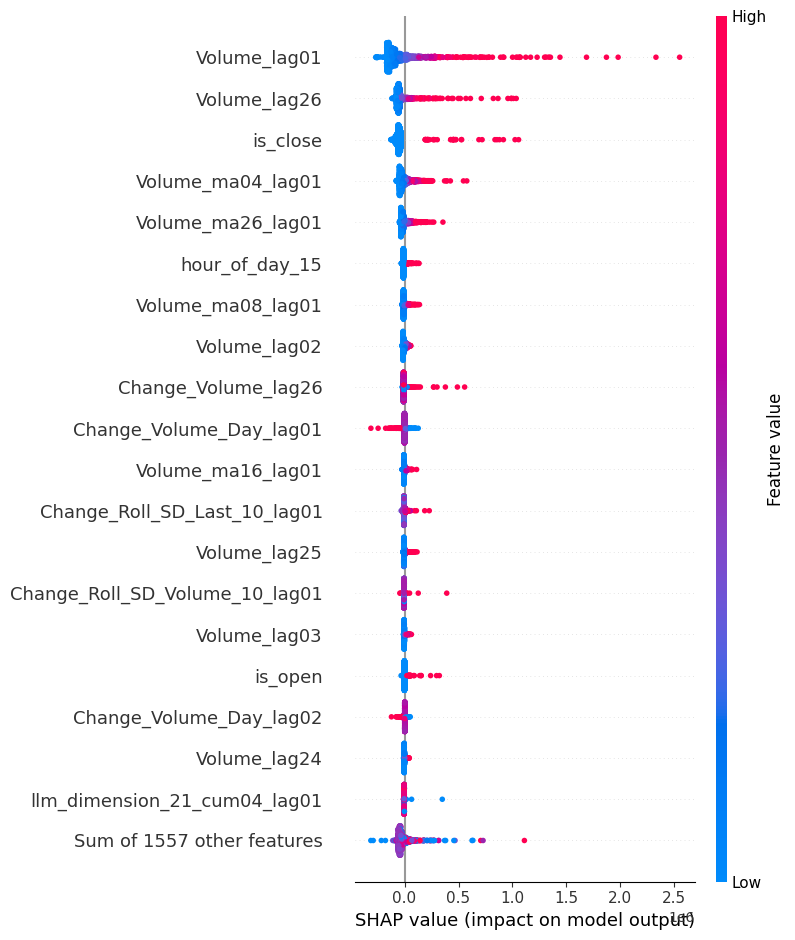

In [107]:
fig = plt.figure(figsize=(10, 15))
fig.add_axes(shap.plots.beeswarm(shap_values, max_display=20, show=False))
fig.tight_layout()
fig.savefig('../../output/shap_beeswarm_all.pdf')

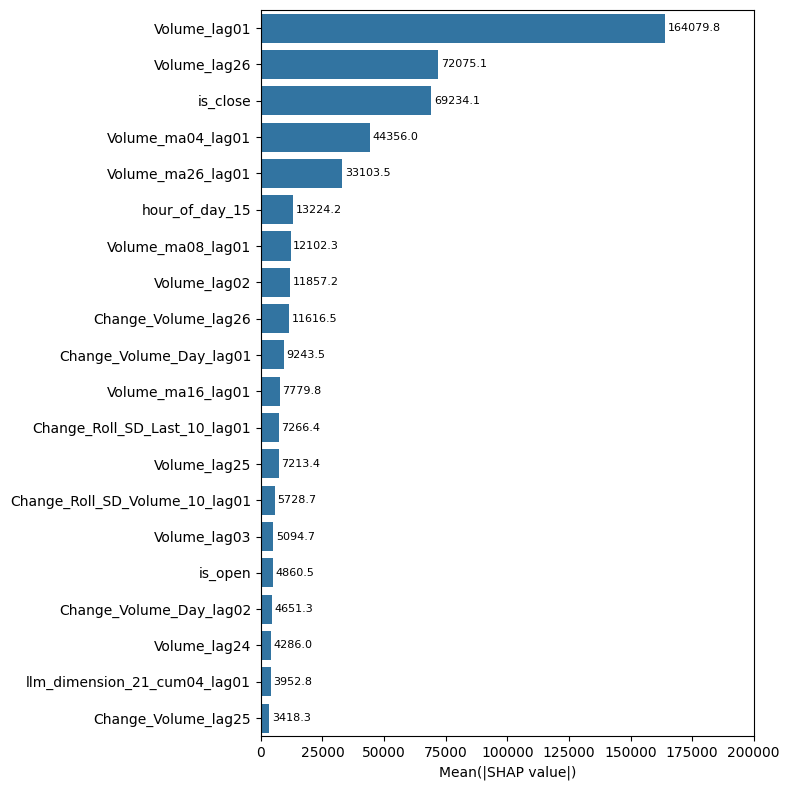

In [110]:
# Plot mean absolute SHAP values
mean_abs_shap = np.abs(shap_values.values).mean(axis=0)
feature_names = x.columns
top_idx = np.argsort(mean_abs_shap)[-20:][::-1]
plt.figure(figsize=(8, 8))
ax = sns.barplot(x=mean_abs_shap[top_idx], y=feature_names[top_idx])
plt.xlim(0, 200000)
plt.xlabel('Mean(|SHAP value|)')
plt.ylabel('')
for i, v in enumerate(mean_abs_shap[top_idx]):
    ax.text(v+1000, i, f'{v:.1f}', va='center', ha='left', fontsize=8)
plt.tight_layout()
plt.savefig('../../output/shap_abs_all.pdf', bbox_inches='tight')

In [ ]:
# Identify the unique sentiment variable names
sentiment_vars = [i.replace('','').replace('_cum04','').replace('_cum16','').replace('_cum48','').replace('_cum96','').replace('_lag01','') for i in sentiment_cols]
sentiment_vars = list(set(sentiment_vars))

df_shap = pd.DataFrame(shap_values.values, columns=x.columns)

for i in sentiment_vars:
    df_shap[i] = np.abs(df_shap[[j for j in df_shap.columns if i in j]].sum(axis=1))
df_shap
df_shap = df_shap[sentiment_vars]
df_agg = df_shap.mean(axis=0).to_frame(name='Mean Absolute Shapley Value').reset_index()
df_agg

index  Mean Absolute Shapley Value
0                           llm_dimension_18                   127.484656
1              c3.4; WORDCOUNT; NEG_POSITIVE                    39.895996
2    c18.36; WORDCOUNT; ECON_DEVELOPMENTORGS                    40.817391
3                  c18.137; WORDCOUNT; TRIAL                   100.052706
4                           llm_dimension_07                   142.252381
..                                       ...                          ...
145          c4.1; WORDCOUNT; MACROECONOMICS                   148.214069
146      v42.10; SCOREDVALUE; authority_sent                   332.858259
147               v42.2; SCOREDVALUE; care_p                   201.489381
148                c3.1; WORDCOUNT; NEGATIVE                   142.599021
149           c18.21; WORDCOUNT; LEGISLATION                   109.403230

[150 rows x 2 columns]

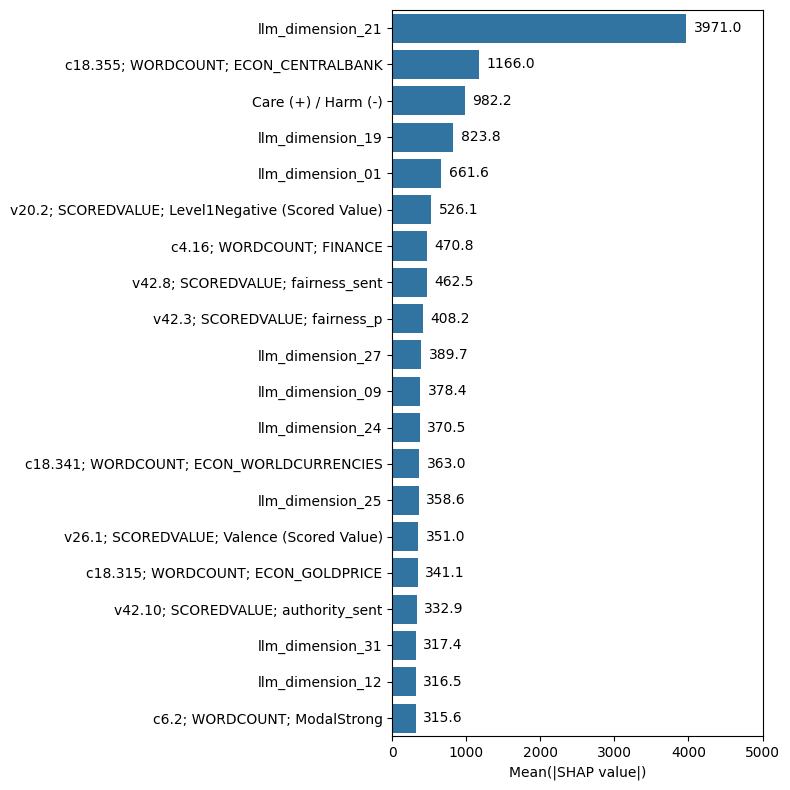

In [ ]:
# Plot mean absolute SHAP values for top sentiment variables
df_plot = df_agg.copy()
df_plot.sort_values(by='Mean Absolute Shapley Value', ascending=False, inplace=True)
df_plot = df_plot.iloc[:20,:]
df_plot['index'] = df_plot['index'].str.replace('v11.1; SCOREDVALUE; Polarity (Scored Value)', 'Polarity').replace('v10.2; SCOREDVALUE; Negative (Scored Value)', 'Negative').replace('v10.1; SCOREDVALUE; Positive (Scored Value)', 'Positive').replace('c18.314; WORDCOUNT; ECON_OILPRICE', 'Oil Price').replace('c18.60; WORDCOUNT; ECON_EARNINGSREPORT', 'Earnings Report').replace('v42.7; SCOREDVALUE; care_sent', 'Care (+) / Harm (-)').replace('v42.11; SCOREDVALUE; sanctity_sent', 'Sanctity (+) / Degradation (-)')

plt.figure(figsize=(8,8))
ax = sns.barplot(data=df_plot, x='Mean Absolute Shapley Value', y='index')
plt.xlim(0, 5000)
plt.xlabel('Mean(|SHAP value|)')
plt.ylabel('')
for i, v in enumerate(df_plot['Mean Absolute Shapley Value']):
    ax.text(v+100, i, f'{v:.1f}', va='center', ha='left', fontsize=10)
plt.tight_layout()
plt.savefig('../../output/shap_abs_sentiment_top20.pdf', bbox_inches='tight')

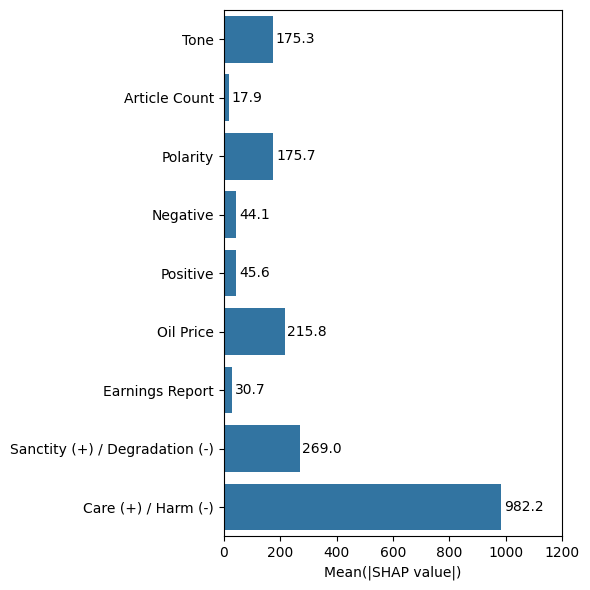

In [ ]:
# Look at traditional sentiment variables shown in the correlation analysis
df_agg = df_agg[df_agg['index'].isin([
    'Tone',
    'Article Count',
    'v11.1; SCOREDVALUE; Polarity (Scored Value)',
    'v10.2; SCOREDVALUE; Negative (Scored Value)',
    'v10.1; SCOREDVALUE; Positive (Scored Value)',
    'c18.314; WORDCOUNT; ECON_OILPRICE',
    'c18.60; WORDCOUNT; ECON_EARNINGSREPORT',
    'v42.7; SCOREDVALUE; care_sent',
    'v42.11; SCOREDVALUE; sanctity_sent',
])]
df_agg['index'] = df_agg['index'].str.replace('v11.1; SCOREDVALUE; Polarity (Scored Value)', 'Polarity').replace('v10.2; SCOREDVALUE; Negative (Scored Value)', 'Negative').replace('v10.1; SCOREDVALUE; Positive (Scored Value)', 'Positive').replace('c18.314; WORDCOUNT; ECON_OILPRICE', 'Oil Price').replace('c18.60; WORDCOUNT; ECON_EARNINGSREPORT', 'Earnings Report').replace('v42.7; SCOREDVALUE; care_sent', 'Care (+) / Harm (-)').replace('v42.11; SCOREDVALUE; sanctity_sent', 'Sanctity (+) / Degradation (-)')

# create a sort order for the index
sort_order = ['Tone', 'Article Count', 'Polarity', 'Negative', 'Positive', 'Oil Price', 'Earnings Report', 'Sanctity (+) / Degradation (-)', 'Care (+) / Harm (-)']
df_agg['index'] = pd.Categorical(df_agg['index'], categories=sort_order, ordered=True)
df_agg = df_agg.sort_values('index')

# Plot mean absolute SHAP values
plt.figure(figsize=(6,6))
ax = sns.barplot(data=df_agg, x='Mean Absolute Shapley Value', y='index')
plt.xlim(0, 1200)
plt.xlabel('Mean(|SHAP value|)')
plt.ylabel('')
for i, v in enumerate(df_agg['Mean Absolute Shapley Value']):
    ax.text(v+10, i, f'{v:.1f}', va='center', ha='left', fontsize=10)
plt.tight_layout()
plt.savefig('../../output/shap_abs_sentiment.pdf', bbox_inches='tight')

In [113]:
# Identify the unique sentiment variable names
sentiment_vars = [i.replace('','').replace('_cum04','').replace('_cum16','').replace('_cum48','').replace('_cum96','').replace('_lag01','') for i in sentiment_cols]
sentiment_vars = list(set(sentiment_vars))

data = pd.DataFrame(x_sample, columns=x.columns)
df_shap = pd.DataFrame(shap_values.values, columns=x.columns)

for i in sentiment_vars:
    df_shap[i] = df_shap[[j for j in df_shap.columns if i in j]].sum(axis=1)
    data[i]    =    data[[j for j in data.columns if i in j]].sum(axis=1)
df_shap = df_shap[sentiment_vars]
data    = data[sentiment_vars]

df_shap = df_shap[[
    'Tone',
    'Article Count',
    'v11.1; SCOREDVALUE; Polarity (Scored Value)',
    'v10.2; SCOREDVALUE; Negative (Scored Value)',
    'v10.1; SCOREDVALUE; Positive (Scored Value)',
    'c18.314; WORDCOUNT; ECON_OILPRICE',
    'c18.60; WORDCOUNT; ECON_EARNINGSREPORT',
    'v42.7; SCOREDVALUE; care_sent',
    'v42.11; SCOREDVALUE; sanctity_sent'
]]
data = data[[
    'Tone',
    'Article Count',
    'v11.1; SCOREDVALUE; Polarity (Scored Value)',
    'v10.2; SCOREDVALUE; Negative (Scored Value)',
    'v10.1; SCOREDVALUE; Positive (Scored Value)',
    'c18.314; WORDCOUNT; ECON_OILPRICE',
    'c18.60; WORDCOUNT; ECON_EARNINGSREPORT',
    'v42.7; SCOREDVALUE; care_sent',
    'v42.11; SCOREDVALUE; sanctity_sent'
]]

df_shap.rename(columns={
    'v11.1; SCOREDVALUE; Polarity (Scored Value)': 'Polarity shap',
    'v10.2; SCOREDVALUE; Negative (Scored Value)': 'Negative shap',
    'v10.1; SCOREDVALUE; Positive (Scored Value)': 'Positive shap',
    'c18.314; WORDCOUNT; ECON_OILPRICE': 'Oil Price shap',
    'c18.60; WORDCOUNT; ECON_EARNINGSREPORT': 'Earnings Report shap',
    'v42.7; SCOREDVALUE; care_sent': 'Care (+) / Harm (-) shap',
    'v42.11; SCOREDVALUE; sanctity_sent': 'Sanctity (+) / Degradation (-) shap'
    }, inplace=True)

data.rename(columns={
    'v11.1; SCOREDVALUE; Polarity (Scored Value)': 'Polarity',
    'v10.2; SCOREDVALUE; Negative (Scored Value)': 'Negative',
    'v10.1; SCOREDVALUE; Positive (Scored Value)': 'Positive',
    'c18.314; WORDCOUNT; ECON_OILPRICE': 'Oil Price',
    'c18.60; WORDCOUNT; ECON_EARNINGSREPORT': 'Earnings Report',
    'v42.7; SCOREDVALUE; care_sent': 'Care (+) / Harm (-)',
    'v42.11; SCOREDVALUE; sanctity_sent': 'Sanctity (+) / Degradation (-)'
    }, inplace=True)

data = pd.concat((data, df_shap), axis=1)

In [114]:
data

Tone  Article Count  Polarity  Negative  Positive  Oil Price  \
0    4.664272       0.144249  0.449654  0.151453  0.146040   0.000000   
1    4.730457       0.041529  0.385502  0.036836  0.041228   0.000000   
2    4.707332       0.000000  0.275877  0.000000  0.000000   0.000000   
3    4.707332       0.000000  0.275877  0.000000  0.000000   0.000000   
4    4.727198       0.114850  0.626272  0.114837  0.118358   0.083678   
..        ...            ...       ...       ...       ...        ...   
995  4.696074       0.025350  0.293249  0.024945  0.026385   0.000000   
996  4.686621       0.066374  0.366572  0.071952  0.072782   0.000000   
997  4.707332       0.000000  0.275877  0.000000  0.000000   0.000000   
998  4.622479       0.274020  0.626373  0.281118  0.270089   0.000000   
999  4.652380       0.255510  0.790492  0.255627  0.254629   0.094371   

     Earnings Report  Care (+) / Harm (-)  Sanctity (+) / Degradation (-)  \
0           0.000000             4.297658                        3.812311   
1           0.000000             4.647790                        4.111259   
2           0.000000             4.745123                        4.132158   
3           0.000000             4.745123                        4.132158   
4           0.033651             4.467617                        3.932036   
..               ...                  ...                             ...   
995         0.000000             4.634787                        4.015357   
996         0.000000             4.546243                        4.001638   
997         0.000000             4.745123                        4.132158   
998         0.000000             3.867846                        3.408966   
999         0.008130             4.202635                        3.618773   

           Tone  Article Count  Polarity shap  Negative shap  Positive shap  \
0   -227.293719     -11.110321     130.445153     184.373680    -395.306093   
1    321.803245      -5.545774     -42.439118      15.019234      -0.964875   
2    -47.101247      -8.025057     161.303358      19.548497      10.318708   
3    -42.450978      -9.722523     163.465068      29.661209       9.490476   
4    204.689858      -2.110577     142.195472      27.690125    -482.312723   
..          ...            ...            ...            ...            ...   
995 -105.832683      -3.499060     208.869532       7.448951      25.409069   
996  -60.386752      -9.590306     137.803183      22.466688     -46.734989   
997  -50.046633      -3.755583     113.748193      18.443720       9.142258   
998  -86.411455      -8.036659      84.196016     -90.640207     -29.150889   
999  362.122204      23.415522    -864.366423     102.277049     -33.245941   

     Oil Price shap  Earnings Report shap  Care (+) / Harm (-) shap  \
0        -77.620356            -59.317771                785.796304   
1       -429.325259            -14.690090              -1730.959512   
2        -51.376542             -9.866346               -786.087880   
3        -58.076892            -10.760206               -731.301067   
4         83.862356             14.357147               4609.571277   
..              ...                   ...                       ...   
995      -54.220653            -19.865792               -455.455472   
996      -62.920662             -8.981431               -366.802804   
997      -51.567726            -15.328978               -721.978337   
998      -48.678026             -9.901637                961.558185   
999      984.337345            127.573214               -195.828759   

     Sanctity (+) / Degradation (-) shap  
0                             -34.427522  
1                            -182.476601  
2                            -233.898026  
3                            -216.218659  
4                             446.766786  
..                                   ...  
995                          -108.419923  
996                          -113.886746  
997               

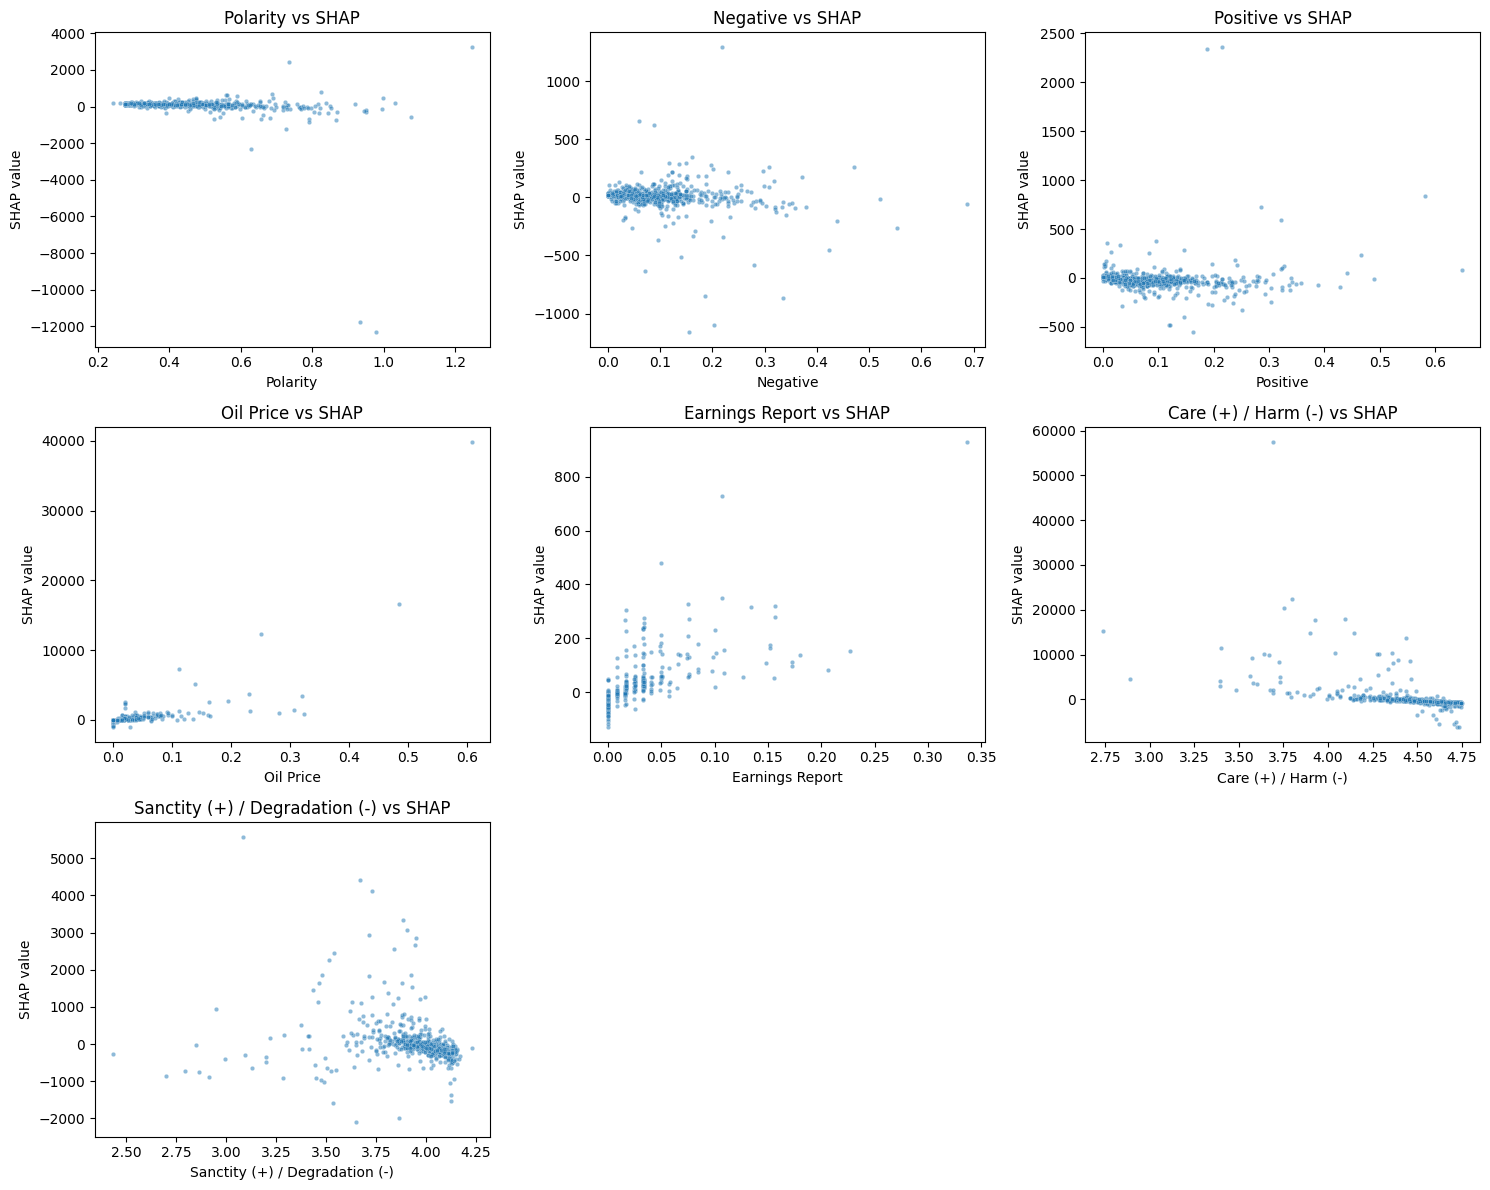

In [ ]:
# Scatterplots of each variable vs its SHAP value, organized in one figure
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))
axes = axes.flatten()

cols_to_graph = ['Polarity','Negative','Positive','Oil Price','Earnings Report','Care (+) / Harm (-)','Sanctity (+) / Degradation (-)']

for idx, col in enumerate(cols_to_graph):
    shap_col = col + ' shap' if not col.endswith('shap') else col
    ax = axes[idx]
    sns.scatterplot(x=data[col], y=data[shap_col], ax=ax, s=10, alpha=0.5)
    ax.set_xlabel(col)
    ax.set_ylabel('SHAP value')
    ax.set_title(f'{col} vs SHAP')

# Hide any unused subplots
for j in range(len(cols_to_graph), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

In [29]:
# Analyze AAL plane crash with and without sentiment effects
df_aal = df[(df['ticker'] == 'AAL') & (df['date'] >= datetime.datetime(2025, 1, 29,13,0,0)) & (df['date'] <= datetime.datetime(2025, 1, 31))].copy()
df_aal = df_aal[x.columns]
df_aal = sc2.transform(df_aal)
explainer = shap.TreeExplainer(model, df_aal, feature_names=x.columns)
shap_aal = explainer(df_aal, check_additivity=True)

In [30]:
df_results = df[(df['ticker'] == 'AAL') & (df['date'] >= datetime.datetime(2025, 1, 29,13,0,0)) & (df['date'] <= datetime.datetime(2025, 1, 31))].copy()

for i in x.columns:
    df_results[f'{i}_shap'] = shap_aal.values[:, x.columns.get_loc(i)]

df_results['Total SHAP'] = df_results[[f'{i}_shap' for i in x.columns]].sum(axis=1)
df_results['Non-Sentiment SHAP'] = df_results[[f'{i}_shap' for i in x.columns if i not in sentiment_cols]].sum(axis=1)
df_results

date ticker  Article Count_cum04_lag01  \
322416 2025-01-29 13:00:00    AAL                          1   
322423 2025-01-29 13:15:00    AAL                          1   
322430 2025-01-29 13:30:00    AAL                          1   
322437 2025-01-29 13:45:00    AAL                          3   
322444 2025-01-29 14:00:00    AAL                          2   
322451 2025-01-29 14:15:00    AAL                          2   
322458 2025-01-29 14:30:00    AAL                          2   
322465 2025-01-29 14:45:00    AAL                          0   
322472 2025-01-29 15:00:00    AAL                          0   
322479 2025-01-29 15:15:00    AAL                          0   
322486 2025-01-29 15:30:00    AAL                          0   
322493 2025-01-29 15:45:00    AAL                          0   
322500 2025-01-30 09:30:00    AAL                         34   
322507 2025-01-30 09:45:00    AAL                         24   
322514 2025-01-30 10:00:00    AAL                         28   
322521 2025-01-30 10:15:00    AAL                         34   
322528 2025-01-30 10:30:00    AAL                         44   
322535 2025-01-30 10:45:00    AAL                         48   
322542 2025-01-30 11:00:00    AAL                         36   
322549 2025-01-30 11:15:00    AAL                         39   
322556 2025-01-30 11:30:00    AAL                         35   
322563 2025-01-30 11:45:00    AAL                         29   
322570 2025-01-30 12:00:00    AAL                         33   
322577 2025-01-30 12:15:00    AAL                         37   
322584 2025-01-30 12:30:00    AAL                         29   
322591 2025-01-30 12:45:00    AAL                         50   
322598 2025-01-30 13:00:00    AAL                         42   
322605 2025-01-30 13:15:00    AAL                         26   
322612 2025-01-30 13:30:00    AAL                         44   
322619 2025-01-30 13:45:00    AAL                         36   
322626 2025-01-30 14:00:00    AAL                         42   
322633 2025-01-30 14:15:00    AAL                         41   
322640 2025-01-30 14:30:00    AAL                         34   
322647 2025-01-30 14:45:00    AAL                         24   
322654 2025-01-30 15:00:00    AAL                         21   
322661 2025-01-30 15:15:00    AAL                         52   
322668 2025-01-30 15:30:00    AAL                         47   
322675 2025-01-30 15:45:00    AAL                         53   

        Article Count_cum16_lag01  Article Count_cum48_lag01  \
322416                          2                         24   
322423                          2                         24   
322430                          2                         23   
322437                          4                         24   
322444                          4                         23   
322451                          3                         22   
322458                          3                         22   
322465                          3                         22   
322472                          3                         21   
322479                          3                         21   
322486                          3                         21   
322493                          3                         20   
322500                         92                        199   
322507                         87                        201   
322514                        102                        217   
322521                        112                        229   
322528                        115                        243   
322535                        119                        249   
322542                        112                        253   
322549                        122                        268   
322556                        126                        277   
322563                        123                        275   
322570                        126                    

In [31]:
predicts = model.predict(df_aal)
df_results['Predicted'] = predicts
df_results = df_results[['date','Volume','Predicted','Total SHAP','Non-Sentiment SHAP']]
df_results['expected'] = shap_aal.base_values
df_results['Predicted Total'] = df_results['expected'] + df_results['Total SHAP']
df_results['Predicted Non-Sentiment'] = df_results['expected'] + df_results['Non-Sentiment SHAP']

In [32]:
df_results['Predicted Total']-df_results['Predicted'] # Why is this not zero?

322416   -1499.783711
322423    -290.906749
322430     352.367562
322437     229.218418
322444    -200.294796
322451     613.756995
322458   -1066.414394
322465    2074.360195
322472    -892.206270
322479     670.436202
322486    1084.922299
322493     884.255427
322500   -7203.873656
322507     175.995565
322514     787.022553
322521    -412.145402
322528     176.003685
322535    -625.380836
322542    5039.319068
322549     265.268793
322556     175.997536
322563     243.799388
322570   -1222.861382
322577     243.945876
322584   -1266.385638
322591   -1263.060024
322598   -1931.700524
322605   -1044.540767
322612    -144.072635
322619    1907.070702
322626    -442.348929
322633    1194.307284
322640    2081.498967
322647   -1139.582881
322654     671.372387
322661     895.301698
322668     703.300965
322675     176.037030
dtype: float64

In [37]:
df_results

date   Volume     Predicted    Total SHAP  \
322416 2025-01-29 13:00:00   939042  7.521520e+05 -5.227136e+05   
322423 2025-01-29 13:15:00   728226  8.325533e+05 -4.411034e+05   
322430 2025-01-29 13:30:00   423361  7.393134e+05 -5.337001e+05   
322437 2025-01-29 13:45:00   259917  5.747552e+05 -6.983814e+05   
322444 2025-01-29 14:00:00   860008  4.821974e+05 -7.913688e+05   
322451 2025-01-29 14:15:00   444092  7.756902e+05 -4.970619e+05   
322458 2025-01-29 14:30:00   697001  5.828730e+05 -6.915593e+05   
322465 2025-01-29 14:45:00   625518  6.515761e+05 -6.197154e+05   
322472 2025-01-29 15:00:00   585487  7.438040e+05 -5.304541e+05   
322479 2025-01-29 15:15:00  1500010  7.854075e+05 -4.872879e+05   
322486 2025-01-29 15:30:00  1017110  1.261915e+06 -1.036552e+04   
322493 2025-01-29 15:45:00  2883198  3.727052e+06  2.454570e+06   
322500 2025-01-30 09:30:00  3666168  3.403304e+06  2.122734e+06   
322507 2025-01-30 09:45:00  1955185  2.633486e+06  1.360297e+06   
322514 2025-01-30 10:00:00  1503242  1.858260e+06  5.856814e+05   
322521 2025-01-30 10:15:00  1783576  1.384188e+06  1.104102e+05   
322528 2025-01-30 10:30:00  1360354  1.770250e+06  4.970599e+05   
322535 2025-01-30 10:45:00  1276380  1.460461e+06  1.864702e+05   
322542 2025-01-30 11:00:00  1253188  1.409715e+06  1.413880e+05   
322549 2025-01-30 11:15:00  1091829  1.352500e+06  7.939895e+04   
322556 2025-01-30 11:30:00  1504775  1.135910e+06 -1.372801e+05   
322563 2025-01-30 11:45:00  1184702  1.300795e+06  2.767308e+04   
322570 2025-01-30 12:00:00  1087965  1.262871e+06 -1.171727e+04   
322577 2025-01-30 12:15:00   621154  1.136730e+06 -1.363921e+05   
322584 2025-01-30 12:30:00   698761  7.260281e+05 -5.486041e+05   
322591 2025-01-30 12:45:00   923045  7.413613e+05 -5.332676e+05   
322598 2025-01-30 13:00:00   647259  9.860153e+05 -2.892823e+05   
322605 2025-01-30 13:15:00  1055189  6.963858e+05 -5.780246e+05   
322612 2025-01-30 13:30:00   821643  9.381792e+05 -3.353307e+05   
322619 2025-01-30 13:45:00   600027  8.832795e+05 -3.881793e+05   
322626 2025-01-30 14:00:00  1163589  8.428612e+05 -4.309470e+05   
322633 2025-01-30 14:15:00   807130  9.247256e+05 -3.474460e+05   
322640 2025-01-30 14:30:00   633536  9.606480e+05 -3.106363e+05   
322647 2025-01-30 14:45:00   712485  8.830769e+05 -3.914286e+05   
322654 2025-01-30 15:00:00   700062  1.097302e+06 -1.753927e+05   
322661 2025-01-30 15:15:00  1626664  1.088291e+06 -1.841799e+05   
322668 2025-01-30 15:30:00  2280035  1.588489e+06  3.158269e+05   
322675 2025-01-30 15:45:00  4899428  4.013501e+06  2.740311e+06   

        Non-Sentiment SHAP      expected  Predicted Total  \
322416       -4.283675e+05  1.273366e+06     7.506522e+05   
322423       -3.649970e+05  1.273366e+06     8.322624e+05   
322430       -4.547406e+05  1.273366e+06     7.396657e+05   
322437       -6.183963e+05  1.273366e+06     5.749845e+05   
322444       -7.156320e+05  1.273366e+06     4.819971e+05   
322451       -3.804967e+05  1.273366e+06     7.763040e+05   
322458       -6.031004e+05  1.273366e+06     5.818066e+05   
322465       -5.340410e+05  1.273366e+06     6.536505e+05   
322472       -4.530753e+05  1.273366e+06     7.429118e+05   
322479       -3.943646e+05  1.273366e+06     7.860780e+05   
322486        1.510649e+05  1.273366e+06     1.263000e+06   
322493        2.616943e+06  1.273366e+06     3.727936e+06   
322500        1.818759e+06  1.273366e+06     3.396100e+06   
322507        1.050539e+06  1.273366e+06     2.633662e+06   
322514        5.016097e+05  1.273366e+06     1.859047e+06   
322521        9.445891e+04  1.273366e+06     1.383776e+06   
322528        4.307395e+05  1.273366e+06     1.770426e+06   
322535        1.368193e+05  1.273366e+06     1.459836e+06   
322542        1.143861e+05  1.273366e+06     1.414754e+06   
322549        7.078740e+04  1.273366e+06     1.352765e+06   
322556       -1.465434e+05  1.273366e+06     1.136086e+06   
322563        2.531322e+04  1.273366e+06     1.301039e+06   
32257

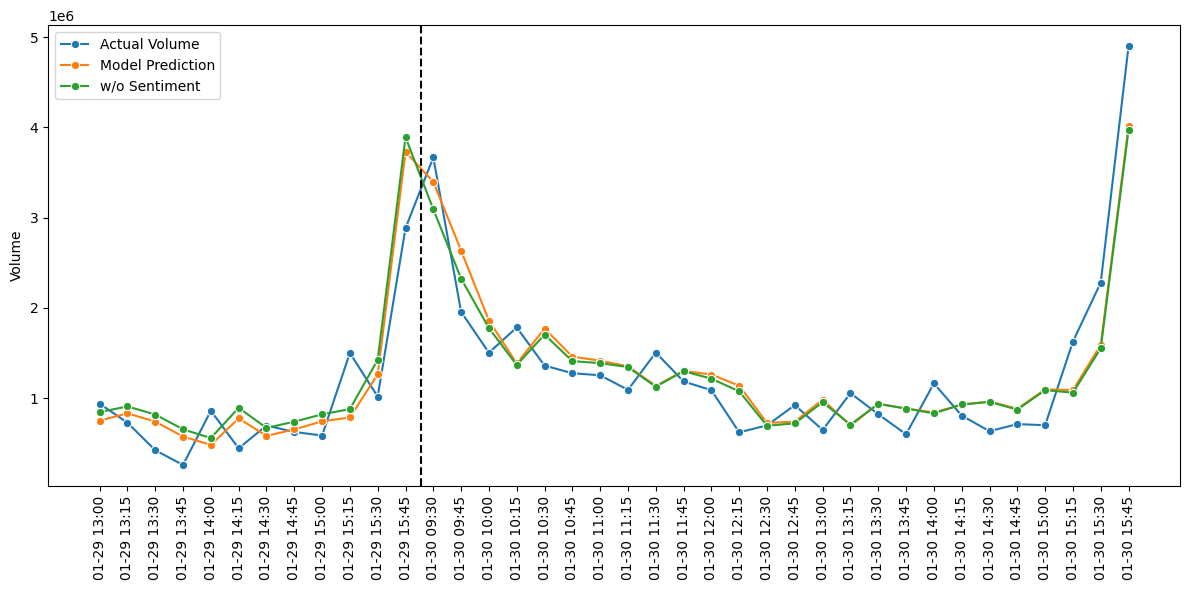

In [39]:
plt.figure(figsize=(12, 6))
ax = sns.lineplot(data=df_results, x=df_results.index, y='Volume'                 , label='Actual Volume', marker='o')
sns.lineplot(data=df_results, x=df_results.index, y='Predicted Total'        , label='Model Prediction', marker='o')
sns.lineplot(data=df_results, x=df_results.index, y='Predicted Non-Sentiment', label='w/o Sentiment', marker='o')

# add a black vertical line at index = 322497
ax.axvline(x=322497, color='black', linestyle='--')

ax.set_xticks(df_results.index)
ax.set_xticklabels(df_results['date'].dt.strftime('%m-%d %H:%M'), rotation=90)
plt.xlabel('')
plt.tight_layout()
plt.savefig('../../output/shap_aal_crash.pdf', bbox_inches='tight')

In [22]:
696385.8327770439+478081.39427696145

1174467.2270540055